## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [3]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [4]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [5]:
#from pandarallel import pandarallel
#pandarallel.initialize(progress_bar=True)

In [6]:
#import itables
#from itables import show

In [7]:
from collections import namedtuple
import itertools
from itertools import product

In [8]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [9]:
import PIL as pil
from PIL import Image, ImageDraw

In [10]:
#import papermill as pm

In [11]:
import math

In [12]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [13]:
import sys
import os

In [14]:
import functools

In [15]:
#import tensorflow as tf

In [16]:
import torch
import torchvision

In [17]:
from einops import *

In [18]:
#import cv2

In [19]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [20]:
import networkx as nx

In [21]:
from pathlib import Path

In [22]:
import umap
#Note: VERY HACKY: Manuallyumap.plot fixed broken deps install.
#import 
#from umap import UMAP

In [23]:
#import warnings
#warnings.filterwarnings('ignore')

## How well does PCA work on our chestnut vs our casuarina data?

In [ ]:
chestnut_df = pd.read_pickle('df_augment.pickle')
casuarina_df = pd.read_pickle('casuarina_embeds.pickle')

In [ ]:
X_chestnut = np.stack(chestnut_df['pre_pca_augment_embeddings'].apply(np.squeeze))
X_casuarina = np.stack(casuarina_df['pre_pca_augment_embeddings'].apply(np.squeeze))

In [34]:
X_chestnut.shape,\
X_casuarina.shape

((1320, 128), (280, 128))

In [35]:
from sklearn.decomposition import PCA

In [36]:
chestnut_PCA = PCA().fit(X_chestnut)
casuarina_PCA = PCA().fit(X_casuarina)

In [46]:
chestnut_PCA.explained_variance_ratio_.shape,\
casuarina_PCA.explained_variance_ratio_.shape

((128,), (128,))

In [91]:
explained_variance_ratios = pd.DataFrame()
explained_variance_ratios['chestnut'] = chestnut_PCA.explained_variance_ratio_
explained_variance_ratios['casuarina'] = casuarina_PCA.explained_variance_ratio_
explained_variance_ratios = pd.melt(explained_variance_ratios)
explained_variance_ratios = explained_variance_ratios.reset_index()
explained_variance_ratios.columns = 'pc #', 'dataset', 'explained_variance_ratio_'
explained_variance_ratios['pc #'] = explained_variance_ratios['pc #'] % 128 + 1
explained_variance_ratios['cumulative evr'] = explained_variance_ratios.groupby('dataset')['explained_variance_ratio_'].transform('cumsum')

<Axes: xlabel='pc #', ylabel='cumulative evr'>

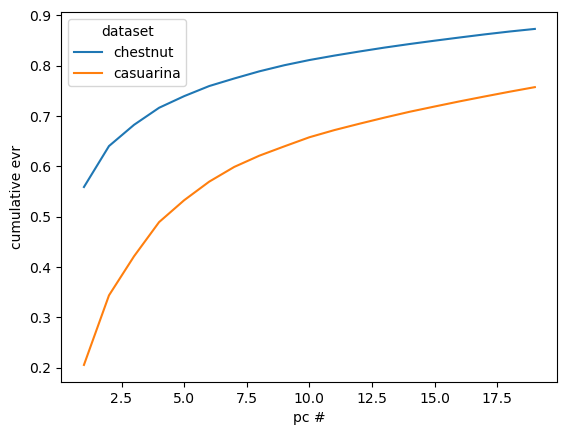

In [97]:
sns.lineplot(explained_variance_ratios[explained_variance_ratios['pc #'] < 20],
             x='pc #',
             y='cumulative evr',
             hue='dataset')

## What if we do Chestnut May vs Chestnut December vs Casuarina?

In [101]:
X_chestnut_may = np.stack(chestnut_df[chestnut_df['phase'] == '10May2021']['pre_pca_augment_embeddings'].apply(np.squeeze))
X_chestnut_december = np.stack(chestnut_df[chestnut_df['phase'] == '18Dec2020']['pre_pca_augment_embeddings'].apply(np.squeeze))
X_casuarina = np.stack(casuarina_df['pre_pca_augment_embeddings'].apply(np.squeeze))

In [104]:
chestnut_december_PCA = PCA().fit(X_chestnut_december)
chestnut_may_PCA = PCA().fit(X_chestnut_may)
casuarina_PCA = PCA().fit(X_casuarina)

In [105]:
explained_variance_ratios = pd.DataFrame()
explained_variance_ratios['chestnut may'] = chestnut_december_PCA.explained_variance_ratio_
explained_variance_ratios['chestnut december'] = chestnut_may_PCA.explained_variance_ratio_
explained_variance_ratios['casuarina'] = casuarina_PCA.explained_variance_ratio_
explained_variance_ratios = pd.melt(explained_variance_ratios)
explained_variance_ratios = explained_variance_ratios.reset_index()
explained_variance_ratios.columns = 'pc #', 'dataset', 'explained_variance_ratio_'
explained_variance_ratios['pc #'] = explained_variance_ratios['pc #'] % 128 + 1
explained_variance_ratios['cumulative evr'] = explained_variance_ratios.groupby('dataset')['explained_variance_ratio_'].transform('cumsum')

<Axes: xlabel='pc #', ylabel='cumulative evr'>

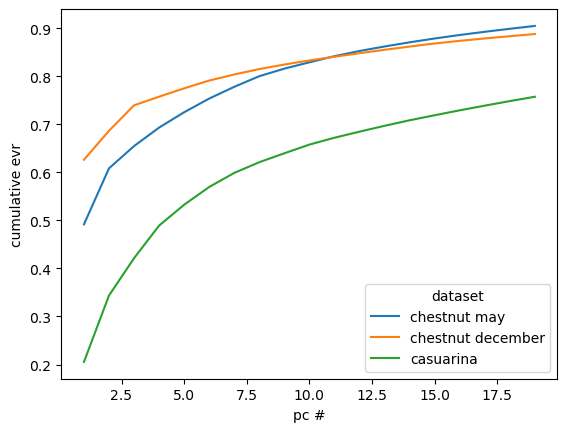

In [106]:
sns.lineplot(explained_variance_ratios[explained_variance_ratios['pc #'] < 20],
             x='pc #',
             y='cumulative evr',
             hue='dataset')

## What if we pick just the CAMPAU from Chestnut and Casuarina?

In [109]:
species = list(chestnut_df['species'].unique())
print(species)

['Alstonia Angulstiloba', 'Bridelia Sp.', 'Calophyllum', 'Campnosperma Auriculatum', 'Cinnamomum Iners', 'Claoxylon Indicum', 'Clausena Excavata', 'Cratoxylum Formosum', 'Dillenia Suffruticosa', 'Falcataria Moluccana', 'Ficus Variegata', 'Leea Indica', 'Pennisetum Purpureum', 'Pometia Pinnata', 'Sandoricum Koetjape', 'Shorea Leprosula', 'Spathodea Campanulatum', 'Sterculia Parviflora', 'Syzygium Polyanthum', 'Terminalia Catappa']


In [113]:
casuarina_trees = list(casuarina_df['name'].unique())
print(casuarina_trees)

['Campnosperma N', 'Campnosperma S', 'Palm Tree', 'macagi top', 'macagi top left', 'macagi middle', 'macagi bottom']


In [114]:
chestnut_df_campau = chestnut_df[chestnut_df['species'] == 'Campnosperma Auriculatum']
casuarina_df_campau = casuarina_df[casuarina_df['name'].apply(lambda x: 'Campnosperma ' in x)]

In [117]:
X_chestnut_campau = np.stack(chestnut_df_campau['pre_pca_augment_embeddings'].apply(np.squeeze))
X_casuarina_campau = np.stack(casuarina_df_campau['pre_pca_augment_embeddings'].apply(np.squeeze))

In [118]:
chestnut_PCA_campau = PCA().fit(X_chestnut_campau)
casuarina_PCA_campau = PCA().fit(X_casuarina_campau)

In [120]:
chestnut_PCA_campau.explained_variance_ratio_.shape,\
casuarina_PCA_campau.explained_variance_ratio_.shape

((40,), (80,))

In [121]:
explained_variance_ratios = pd.DataFrame()
explained_variance_ratios['chestnut only campau'] = chestnut_PCA_campau.explained_variance_ratio_[:20]
explained_variance_ratios['casuarina only campau'] = casuarina_PCA_campau.explained_variance_ratio_[:20]
explained_variance_ratios = pd.melt(explained_variance_ratios)
explained_variance_ratios = explained_variance_ratios.reset_index()
explained_variance_ratios.columns = 'pc #', 'dataset', 'explained_variance_ratio_'
explained_variance_ratios['pc #'] = explained_variance_ratios['pc #'] % 20 + 1
explained_variance_ratios['cumulative evr'] = explained_variance_ratios.groupby('dataset')['explained_variance_ratio_'].transform('cumsum')

<Axes: xlabel='pc #', ylabel='cumulative evr'>

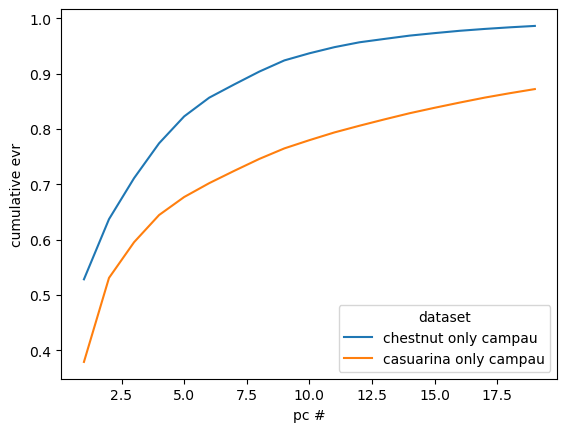

In [122]:
sns.lineplot(explained_variance_ratios[explained_variance_ratios['pc #'] < 20],
             x='pc #',
             y='cumulative evr',
             hue='dataset')

## What if we equalise the number of rows?

In [123]:
chestnut_df_campau = chestnut_df[chestnut_df['species'] == 'Campnosperma Auriculatum']
casuarina_df_campau = casuarina_df[casuarina_df['name'].apply(lambda x: 'Campnosperma ' in x)]

In [124]:
chestnut_df_campau.shape,\
casuarina_df_campau.shape

((40, 10), (80, 11))

In [125]:
casuarina_df_campau = casuarina_df_campau.sample(len(chestnut_df_campau))

<Axes: xlabel='pc #', ylabel='cumulative evr'>

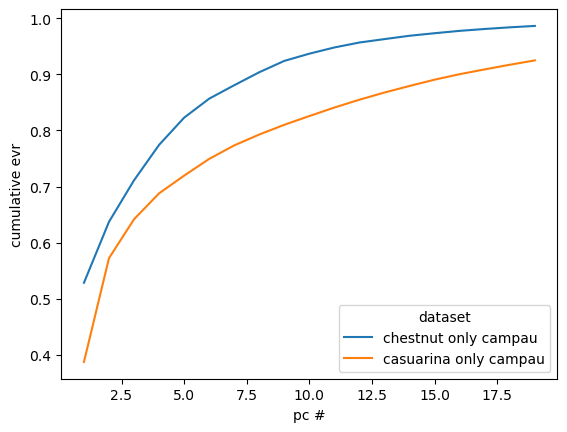

In [126]:
X_chestnut_campau = np.stack(chestnut_df_campau['pre_pca_augment_embeddings'].apply(np.squeeze))
X_casuarina_campau = np.stack(casuarina_df_campau['pre_pca_augment_embeddings'].apply(np.squeeze))

chestnut_PCA_campau = PCA().fit(X_chestnut_campau)
casuarina_PCA_campau = PCA().fit(X_casuarina_campau)

chestnut_PCA_campau.explained_variance_ratio_.shape,\
casuarina_PCA_campau.explained_variance_ratio_.shape

explained_variance_ratios = pd.DataFrame()
explained_variance_ratios['chestnut only campau'] = chestnut_PCA_campau.explained_variance_ratio_[:20]
explained_variance_ratios['casuarina only campau'] = casuarina_PCA_campau.explained_variance_ratio_[:20]
explained_variance_ratios = pd.melt(explained_variance_ratios)
explained_variance_ratios = explained_variance_ratios.reset_index()
explained_variance_ratios.columns = 'pc #', 'dataset', 'explained_variance_ratio_'
explained_variance_ratios['pc #'] = explained_variance_ratios['pc #'] % 20 + 1
explained_variance_ratios['cumulative evr'] = explained_variance_ratios.groupby('dataset')['explained_variance_ratio_'].transform('cumsum')

sns.lineplot(explained_variance_ratios[explained_variance_ratios['pc #'] < 20],
             x='pc #',
             y='cumulative evr',
             hue='dataset')

## What does a PCA of our Chestnut vs our Casuarina embeddings look like?



In [127]:
X_chestnut_may = np.stack(chestnut_df[chestnut_df['phase'] == '10May2021']['pre_pca_augment_embeddings'].apply(np.squeeze))
X_chestnut_december = np.stack(chestnut_df[chestnut_df['phase'] == '18Dec2020']['pre_pca_augment_embeddings'].apply(np.squeeze))
X_casuarina = np.stack(casuarina_df['pre_pca_augment_embeddings'].apply(np.squeeze))

In [135]:
chestnut_december_PCA = PCA(n_components=2).fit(X_chestnut_december)
chestnut_may_PCA = PCA(n_components=2).fit(X_chestnut_may)
casuarina_PCA = PCA(n_components=2).fit(X_casuarina)

In [136]:
X_chestnut_may_trans = chestnut_may_PCA.transform(X_chestnut_may)
X_chestnut_december_trans = chestnut_december_PCA.transform(X_chestnut_december)
X_casuarina_trans = casuarina_PCA.transform(X_casuarina)

In [147]:
post_pca = pd.DataFrame()
post_pca['pc1'] = np.concatenate((X_chestnut_may_trans[:,0],
                                  X_chestnut_december_trans[:,0],
                                  X_casuarina_trans[:,0]))
post_pca['pc2'] = np.concatenate((X_chestnut_may_trans[:,1],
                                  X_chestnut_december_trans[:,1],
                                  X_casuarina_trans[:,1]))
post_pca['source'] =\
    ['chestnut may'] * X_chestnut_may_trans.shape[0]\
    + ['chestnut december'] * X_chestnut_december_trans.shape[0]\
    + ['casuarina'] * X_casuarina_trans.shape[0]

<Axes: xlabel='pc1', ylabel='pc2'>

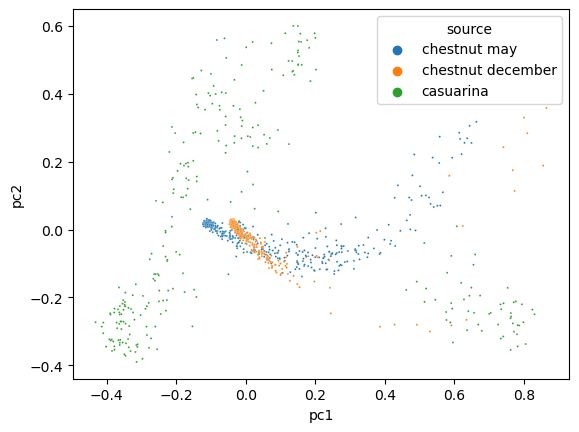

In [151]:
sns.scatterplot(post_pca,
                x='pc1', 
                y='pc2',
                hue='source',
                s=2)

## What about with solely Campau?

In [162]:
chestnut_df_campau = chestnut_df[chestnut_df['species'] == 'Campnosperma Auriculatum']
casuarina_df_campau = casuarina_df[casuarina_df['name'].apply(lambda x: 'Campnosperma ' in x)]

In [163]:
X_chestnut_may_campau = np.stack(chestnut_df_campau[chestnut_df_campau['phase'] == '10May2021']['pre_pca_augment_embeddings'].apply(np.squeeze))
X_chestnut_december_campau = np.stack(chestnut_df_campau[chestnut_df_campau['phase'] == '18Dec2020']['pre_pca_augment_embeddings'].apply(np.squeeze))
X_casuarina_campau = np.stack(casuarina_df_campau['pre_pca_augment_embeddings'].apply(np.squeeze))

In [164]:
chestnut_may_PCA_campau = PCA().fit(X_chestnut_may_campau)
chestnut_december_PCA_campau = PCA().fit(X_chestnut_december_campau)
casuarina_PCA_campau = PCA().fit(X_casuarina_campau)

In [165]:
X_chestnut_may_campau_trans = chestnut_may_PCA_campau.transform(X_chestnut_may_campau)
X_chestnut_december_campau_trans = chestnut_december_PCA_campau.transform(X_chestnut_december_campau)
X_casuarina_campau_trans = casuarina_PCA_campau.transform(X_casuarina_campau)

In [166]:
post_pca = pd.DataFrame()
post_pca['pc1'] = np.concatenate((X_chestnut_may_campau_trans[:,0],
                                  X_chestnut_december_campau_trans[:,0],
                                  X_casuarina_campau_trans[:,0]))
post_pca['pc2'] = np.concatenate((X_chestnut_may_campau_trans[:,1],
                                  X_chestnut_december_campau_trans[:,1],
                                  X_casuarina_campau_trans[:,1]))
post_pca['source'] =\
    ['chestnut may'] * X_chestnut_may_campau_trans.shape[0]\
    + ['chestnut december'] * X_chestnut_december_campau_trans.shape[0]\
    + ['casuarina'] * X_casuarina_campau_trans.shape[0]

<Axes: xlabel='pc1', ylabel='pc2'>

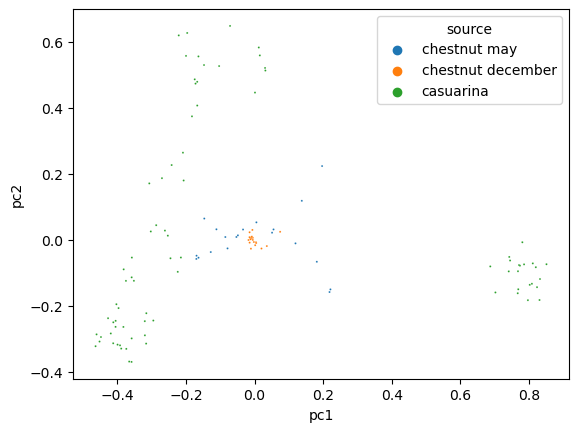

In [167]:
sns.scatterplot(post_pca,
                x='pc1', 
                y='pc2',
                hue='source',
                s=2)

## Can we get our old GLCM per-pixel stuff back for chestnut?

In [49]:
chestnut_per_pixel_metadata_df = pd.read_pickle('df_metadata.pickle')

In [50]:
chestnut_per_pixel_glcm_df = pd.read_pickle('df_glcm3.pickle')

In [51]:
chestnut_per_pixel_df = chestnut_per_pixel_metadata_df.join(chestnut_per_pixel_glcm_df)

In [52]:
#X_glcm_may = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '10May2021'].iloc[:,5:].to_numpy()
#X_glcm_dec = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '18Dec2020'].iloc[:,5:].to_numpy()

In [53]:
chestnut_per_pixel_df = chestnut_per_pixel_df[[i for i in chestnut_per_pixel_df.columns
                                               if not isinstance(i, tuple) or i[0] == 'zl_2_crop_props']]

In [54]:
chestnut_per_pixel_df.columns = [i if not isinstance(i, tuple) else i[1:]
                                 for i in chestnut_per_pixel_df.columns]

In [55]:
chestnut_per_pixel_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4224 entries, (0, 0, 0) to (66, 63, 0)
Data columns (total 65 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  4224 non-null   object 
 1   src                   4224 non-null   object 
 2   (wr, mean_no_glcm)    4224 non-null   float64
 3   (wr, mean)            4224 non-null   float64
 4   (wr, var)             4224 non-null   float64
 5   (wr, contrast)        4224 non-null   float64
 6   (wr, dissimilarity)   4224 non-null   float64
 7   (wr, homogeneity)     4224 non-null   float64
 8   (wr, ASM)             4224 non-null   float64
 9   (wr, energy)          4224 non-null   float64
 10  (wr, correlation)     4224 non-null   float64
 11  (wg, mean_no_glcm)    4224 non-null   float64
 12  (wg, mean)            4224 non-null   float64
 13  (wg, var)             4224 non-null   float64
 14  (wg, contrast)        4224 non-null   float64
 15  (wg, d

## Reproduce our prior decision boundaries viz

In [56]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

In [57]:
species = list(chestnut_per_pixel_df['name'].unique())

In [58]:
species_dfs = [chestnut_per_pixel_df[chestnut_per_pixel_df['name'] == name] for name in species]

In [59]:
chestnut_per_pixel_df = pd.concat(species_dfs)

In [60]:
chestnut_per_pixel_df = chestnut_per_pixel_df.reset_index()

In [228]:
X_glcm_may = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '10May2021'].iloc[:,5:]
X_glcm_dec = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '18Dec2020'].iloc[:,5:]

In [229]:
y_may = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '10May2021']['name']
y_dec = chestnut_per_pixel_df[chestnut_per_pixel_df['src'] == '18Dec2020']['name']

In [230]:
le = LabelEncoder()
le.classes_ = np.asarray(species)

pca = PCA(n_components=2).set_output(transform='pandas')
pca.fit(X_glcm_may)

lda = LinearDiscriminantAnalysis(n_components=2).set_output(transform='pandas')
lda.fit(X_glcm_may, y_may)

pca_sc = StandardScaler().set_output(transform='pandas')
pca_sc.fit(pca.transform(X_glcm_may))

lda_sc = StandardScaler().set_output(transform='pandas')
lda_sc.fit(lda.transform(X_glcm_may))

pca_X_may = lda_sc.transform(lda.transform(X_glcm_may))
pca_X_dec = lda_sc.transform(lda.transform(X_glcm_dec))

lda_X_may = lda_sc.transform(lda.transform(X_glcm_may))
lda_X_dec = lda_sc.transform(lda.transform(X_glcm_dec))

pca_svc = SVC(C=10**5, gamma=3.236)
pca_svc.fit(pca_X_may, le.transform(y_may))

lda_svc = SVC(C=10**5, gamma=0.7943)
lda_svc.fit(lda_X_may, le.transform(y_may))

SVC(C=100000, gamma=0.7943)

Text(0.5, 0.98, 'Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

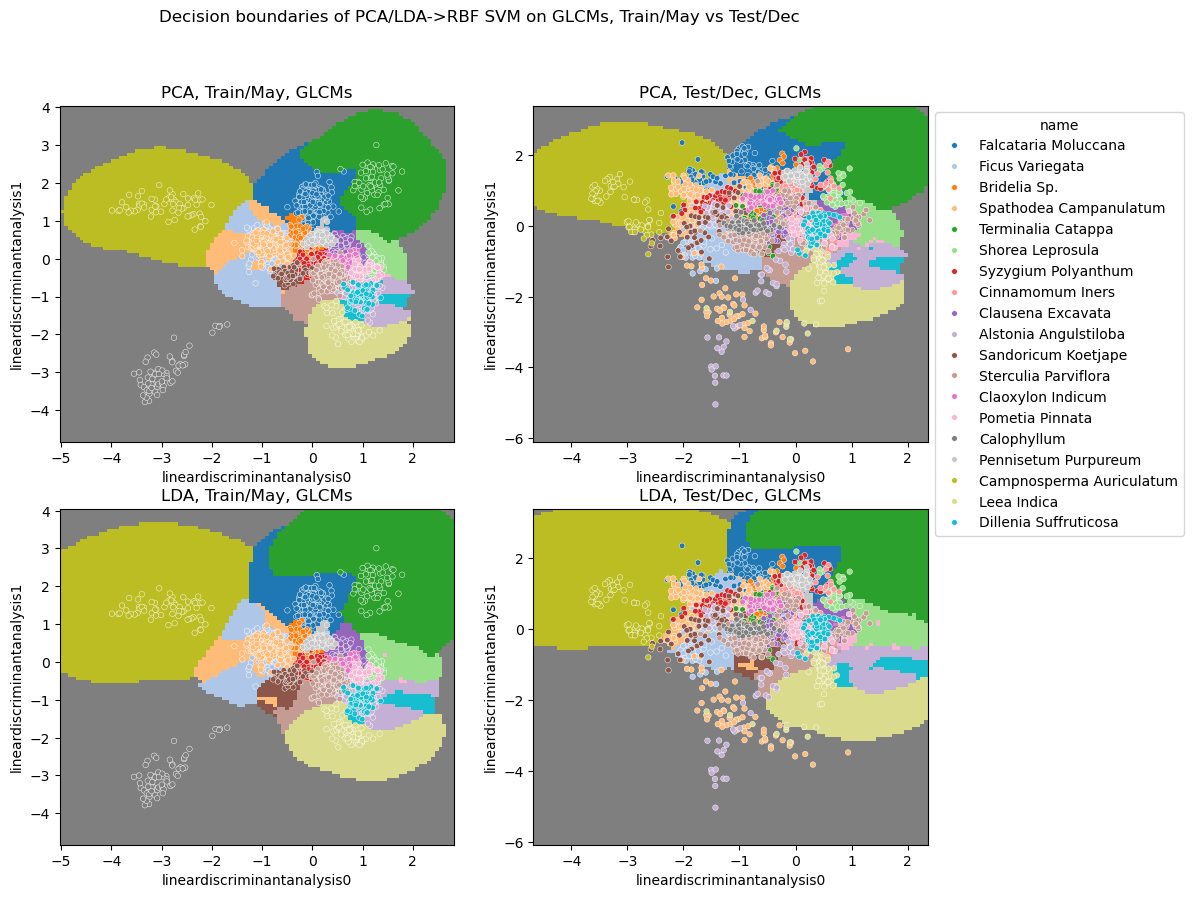

In [232]:
fig, ax = plt.subplots(2, 2, figsize=(5.6*2, 4.8*2))
estimators = [pca_svc, pca_svc, lda_svc, lda_svc]
datas_X = [pca_X_may, pca_X_dec, lda_X_may, lda_X_dec]
datas_y = [y_may, y_dec, y_may, y_dec]
for estimator, X, y, ax_ in zip(estimators, datas_X, datas_y, ax.flatten()):
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="predict",
        cmap=matplotlib.colors.ListedColormap([plt.cm.tab20(i) for i in range(19)]),
        plot_method='pcolormesh',
        ax=ax_
    )
    sns.scatterplot(
        x=X.iloc[:,0],
        y=X.iloc[:,1],
        hue=y,
        palette='tab20',
        legend=False if ax_ != ax[0][-1] else True,
        s=16,
        ax=ax_
    )
    if ax_ == ax[0][-1]:
        sns.move_legend(ax_, "upper left", bbox_to_anchor=(1, 1))
ax[0][0].set_title('PCA, Train/May, GLCMs')
ax[0][1].set_title('PCA, Test/Dec, GLCMs')
ax[1][0].set_title('LDA, Train/May, GLCMs')
ax[1][1].set_title('LDA, Test/Dec, GLCMs')
fig.suptitle('Decision boundaries of PCA/LDA->RBF SVM on GLCMs, Train/May vs Test/Dec')

## What about with a PCA of the Facenet data?

In [35]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

In [24]:
chestnut_df = pd.read_pickle('df_augment.pickle')
casuarina_df = pd.read_pickle('casuarina_embeds.pickle')

In [25]:
species = [i for i in chestnut_df['species'].unique()]

In [26]:
species_dfs = [chestnut_df[chestnut_df['species'] == name] for name in species]

In [27]:
chestnut_df = pd.concat(species_dfs)

In [28]:
chestnut_df = chestnut_df.reset_index()

In [29]:
chestnut_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   index                       1320 non-null   int64   
 1   npz_path                    1320 non-null   object  
 2   path_str_split              1320 non-null   object  
 3   phase                       1320 non-null   category
 4   filename                    1320 non-null   object  
 5   species                     1320 non-null   category
 6   tree_id                     1320 non-null   int32   
 7   glcm                        1320 non-null   object  
 8   sel_features                1320 non-null   object  
 9   pre_pca_augment             1320 non-null   object  
 10  pre_pca_augment_embeddings  1320 non-null   object  
dtypes: category(2), int32(1), int64(1), object(7)
memory usage: 91.2+ KB


In [30]:
X_glcm_may = np.stack(chestnut_df[chestnut_df['phase'] == '10May2021']['pre_pca_augment_embeddings'].apply(np.squeeze))
X_glcm_dec = np.stack(chestnut_df[chestnut_df['phase'] == '18Dec2020']['pre_pca_augment_embeddings'].apply(np.squeeze))

In [31]:
y_may = chestnut_df[chestnut_df['phase'] == '10May2021']['species']
y_dec = chestnut_df[chestnut_df['phase'] == '18Dec2020']['species']

In [32]:
le = LabelEncoder()
le.classes_ = np.asarray(species)

pca = PCA(n_components=2).set_output(transform='pandas')
pca.fit(X_glcm_may)

lda = LinearDiscriminantAnalysis(n_components=2).set_output(transform='pandas')
lda.fit(X_glcm_may, y_may)

pca_sc = StandardScaler().set_output(transform='pandas')
pca_sc.fit(pca.transform(X_glcm_may))

lda_sc = StandardScaler().set_output(transform='pandas')
lda_sc.fit(lda.transform(X_glcm_may))

pca_X_may = lda_sc.transform(lda.transform(X_glcm_may))
pca_X_dec = lda_sc.transform(lda.transform(X_glcm_dec))

lda_X_may = lda_sc.transform(lda.transform(X_glcm_may))
lda_X_dec = lda_sc.transform(lda.transform(X_glcm_dec))

pca_svc = SVC(C=10**5, gamma=3.236)
pca_svc.fit(pca_X_may, le.transform(y_may))

lda_svc = SVC(C=10**5, gamma=0.7943)
lda_svc.fit(lda_X_may, le.transform(y_may))

SVC(C=100000, gamma=0.7943)

In [33]:
len(le.classes_)

20

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
E:\miniconda3\envs\up-to-date-env\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision boundaries of PCA/LDA->RBF SVM on Facenet embeddings, Train/May vs Test/Dec')

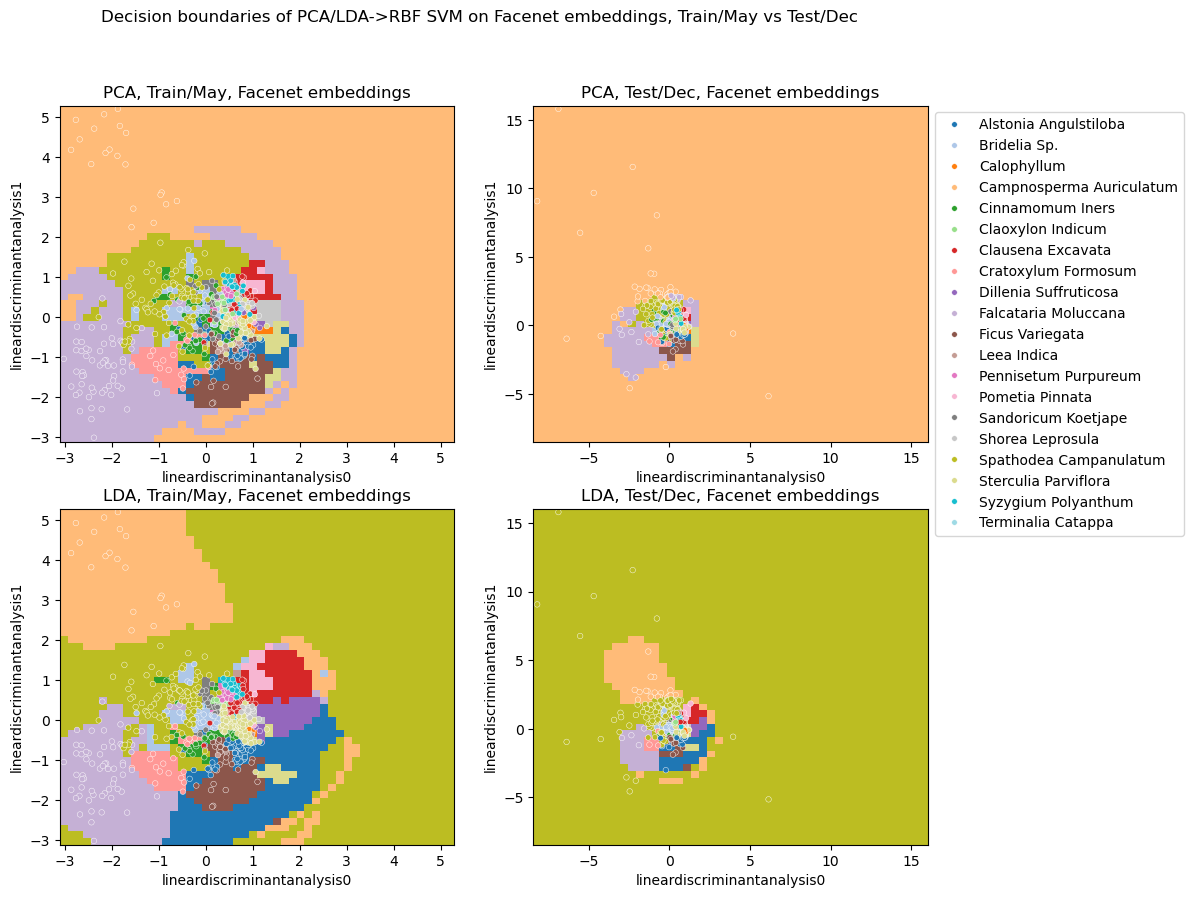

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(5.6*2, 4.8*2))
estimators = [pca_svc, pca_svc, lda_svc, lda_svc]
datas_X = [pca_X_may, pca_X_dec, lda_X_may, lda_X_dec]
datas_y = [y_may, y_dec, y_may, y_dec]
for estimator, X, y, ax_ in zip(estimators, datas_X, datas_y, ax.flatten()):
    mesh_x0, mesh_x1 = np.meshgrid(*((np.linspace(np.min(X), np.max(X)),)*2))
    mesh_x = np.stack((mesh_x0.flatten(), mesh_x1.flatten()), axis=1)
    mesh_y = estimator.predict(mesh_x)
    C = [plt.cm.tab20(i) for i in mesh_y]
    C = np.asarray(C)
    C = C.reshape(mesh_x0.shape + (4,))
    
    ax_.pcolormesh(
        mesh_x0,
        mesh_x1,
        C,
    )
    
    #DecisionBoundaryDisplay.from_estimator(
    #    estimator,
    #    X,
    #    response_method="predict",
    #    cmap=matplotlib.colors.ListedColormap([plt.cm.tab20(i) for i in range(len(le.classes_))]),
    #    plot_method='pcolormesh',
    #    ax=ax_
    #)

    sns.scatterplot(
        x=X.iloc[:,0],
        y=X.iloc[:,1],
        hue=le.inverse_transform(estimator.predict(X)),
        palette='tab20',
        hue_order=species,
        legend=False if ax_ != ax[0][-1] else True,
        s=16,
        ax=ax_
    )
    if ax_ == ax[0][-1]:
        sns.move_legend(ax_, "upper left", bbox_to_anchor=(1, 1))
ax[0][0].set_title('PCA, Train/May, Facenet embeddings')
ax[0][1].set_title('PCA, Test/Dec, Facenet embeddings')
ax[1][0].set_title('LDA, Train/May, Facenet embeddings')
ax[1][1].set_title('LDA, Test/Dec, Facenet embeddings')
fig.suptitle('Decision boundaries of PCA/LDA->RBF SVM on Facenet embeddings, Train/May vs Test/Dec')

## Explained variance ratios of GLCM stats vs Facenet?

In [61]:
X_facenet = np.stack(chestnut_df['pre_pca_augment_embeddings'].apply(np.squeeze))
X_glcm = chestnut_per_pixel_df.iloc[:,5:].to_numpy()

In [62]:
facenet_PCA = PCA().fit(X_facenet)
glcm_PCA = PCA().fit(X_glcm)

In [68]:
explained_variance_ratios = pd.DataFrame()
explained_variance_ratios['chestnut facenet'] = facenet_PCA.explained_variance_ratio_[:63]
explained_variance_ratios['chestnut glcm'] = glcm_PCA.explained_variance_ratio_[:63]
explained_variance_ratios = pd.melt(explained_variance_ratios)
explained_variance_ratios = explained_variance_ratios.reset_index()
explained_variance_ratios.columns = 'pc #', 'dataset', 'explained_variance_ratio_'
explained_variance_ratios['pc #'] = explained_variance_ratios['pc #'] % 63 + 1
explained_variance_ratios['cumulative evr'] = explained_variance_ratios.groupby('dataset')['explained_variance_ratio_'].transform('cumsum')

In [69]:
explained_variance_ratios

,pc #,dataset,explained_variance_ratio_,cumulative evr
0,1,chestnut facenet,5.589380e-01,0.558938
1,2,chestnut facenet,8.137620e-02,0.640314
2,3,chestnut facenet,4.217805e-02,0.682492
3,4,chestnut facenet,3.389011e-02,0.716382
4,5,chestnut facenet,2.308042e-02,0.739463
...,...,...,...,...
121,59,chestnut glcm,4.434520e-13,1.000000
122,60,chestnut glcm,3.800402e-13,1.000000
123,61,chestnut glcm,2.079127e-13,1.000000
124,62,chestnut glcm,1.529959e-13,1.000000


<Axes: xlabel='pc #', ylabel='cumulative evr'>

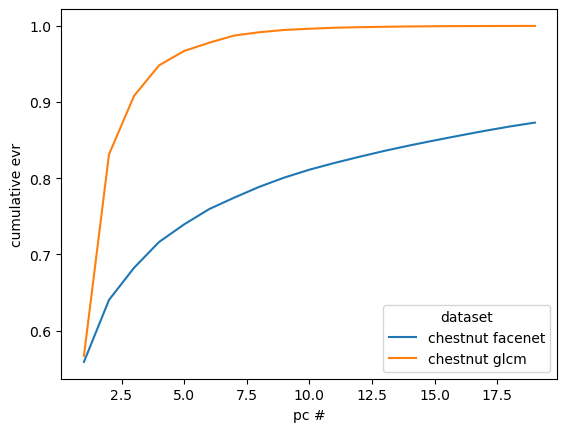

In [70]:
sns.lineplot(explained_variance_ratios[explained_variance_ratios['pc #'] < 20],
             x='pc #',
             y='cumulative evr',
             hue='dataset')